<a href="https://colab.research.google.com/github/baerenstein/qFinance/blob/main/Forecasting_Crude_Oil_Price_Volatility_by_Heston_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Forecasting Crude Oil Price Volatility by Heston Model
An adapted notebook based on the paper by
*Mwanakatwe, P.K., Daniel, J. and Nzungu, K.R. (2023) Forecasting Crude Oil Price Volatility by Heston
Model. Journal of Mathematical Finance,
13, 408-420*

In [ ]:
!pip install tf_quant_finance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from numpy import sqrt,mean,log,diff
from datetime import date, datetime
import time

import yfinance as yf

# import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# import deep learning and finance models
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tf_quant_finance as tff

In [ ]:
option_price = tff.black_scholes.option_price
implied_vol = tff.black_scholes.implied_vol

from IPython.core.pylabtools import figsize
figsize(21, 14) # better graph size for Colab

In [ ]:
def getOption(symbol, toCSV = True, timeIt = False, bareMinimum = False, rawData = False):

    """
    This function inputs a symbol (string) and outputs the options data for this stock
    toCSV: if true, outputs the single option's data as a csv
    bareMinimum: returns only name, date, strike price, bid, ask, call/put, last stock price
    rawData: doesn't take out calls or puts that aren't in the money, doesn't remove mini options
    timeIt: if true, returns how long executing this took
    """

    start = time.time()
    # get stock price
    sym = yf.Ticker(symbol)
    data = sym.history()
    price = (data.tail(1)['Close'].iloc[0]) #gets latest closing price

    # get the options chain for each expiration
    # Expiration dates
    exps = sym.options

    allOpt = pd.DataFrame()
    for e in exps:
        opt = sym.option_chain(e)

        # get puts and calls: assign them 0 and 1
        calls = opt.calls
        calls['type'] = 0
        puts = opt.puts
        puts['type'] = 1

        # merge everything together and add on the expiration date
        opt = pd.DataFrame().append(calls).append(puts)
        opt['expirationDate'] = e
        allOpt = allOpt.append(opt, ignore_index=True)

    # check bare minimum:
    if(bareMinimum):
        dropThese = ['change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'currency']
        allOpt.drop(dropThese, axis = 1, inplace = True) #reduces from 137 kb to 80 kb in case of apple
    if(not rawData):
        #r emove any mini options (not regular), and bad puts and calls, etc.
        allOpt.drop(allOpt[(allOpt.type == 0) & (allOpt.strike <= price)].index, inplace = True)
        allOpt.drop(allOpt[(allOpt.type == 1) & (allOpt.strike >= price)].index, inplace = True)
        allOpt.drop(allOpt[allOpt.contractSize != "REGULAR"].index, inplace = True)

    # add price column
    allOpt['lastPrice'] = price

    # for testing purposes: export to CSV
    if(toCSV):
        allOpt.to_csv("oneOpt.csv")

    end = time.time()
    if(timeIt):
        print("The time of execution of above program is :", end-start)

    #return the data
    return allOpt

In [ ]:
allOpt = getOption('ICLN')

In [ ]:
allOpt.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,expirationDate
4,ICLN231229C00015500,2023-12-22 20:06:03+00:00,15.5,15.39,0.15,0.25,-0.02,-10.526314,1.0,181,0.382819,False,REGULAR,USD,0,2023-12-29
5,ICLN231229C00016000,2023-12-22 20:00:07+00:00,16.0,15.39,0.05,0.10,-0.03,-30.000002,6.0,5,0.394537,False,REGULAR,USD,0,2023-12-29
6,ICLN231229P00012500,2023-11-27 18:40:19+00:00,12.5,15.39,0.00,2.05,0.00,0.000000,NaN,1,3.074221,False,REGULAR,USD,1,2023-12-29
7,ICLN231229P00013000,2023-12-05 19:58:29+00:00,13.0,15.39,0.00,0.20,0.00,0.000000,2.0,11,1.062505,False,REGULAR,USD,1,2023-12-29
8,ICLN231229P00013500,2023-12-01 15:36:10+00:00,13.5,15.39,0.00,0.55,0.00,0.000000,3.0,11,1.261722,False,REGULAR,USD,1,2023-12-29


In [ ]:
allOpt.tail()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,expirationDate
233,ICLN260116P00008000,2023-11-22 20:55:26+00:00,8.0,15.39,0.00,0.65,0.0,0.0,NaN,5,0.472662,False,REGULAR,USD,1,2026-01-16
234,ICLN260116P00010000,2023-12-04 14:46:03+00:00,10.0,15.39,0.25,0.50,0.0,0.0,2.0,3,0.313972,False,REGULAR,USD,1,2026-01-16
235,ICLN260116P00012000,2023-12-06 16:39:59+00:00,12.0,15.39,0.60,0.85,0.0,0.0,6.0,57,0.274421,False,REGULAR,USD,1,2026-01-16
236,ICLN260116P00013000,2023-12-19 19:39:25+00:00,13.0,15.39,0.85,1.10,0.0,0.0,1.0,30,0.257576,False,REGULAR,USD,1,2026-01-16
237,ICLN260116P00015000,2023-12-06 16:37:13+00:00,15.0,15.39,1.45,1.95,0.0,0.0,NaN,48,0.246834,False,REGULAR,USD,1,2026-01-16


In [ ]:
allOpt.columns

Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'type',
       'expirationDate'],
      dtype='object')

## Volatility Skew

<Axes: title={'center': 'Implied Volatility Skew Near Term'}, xlabel='strike'>

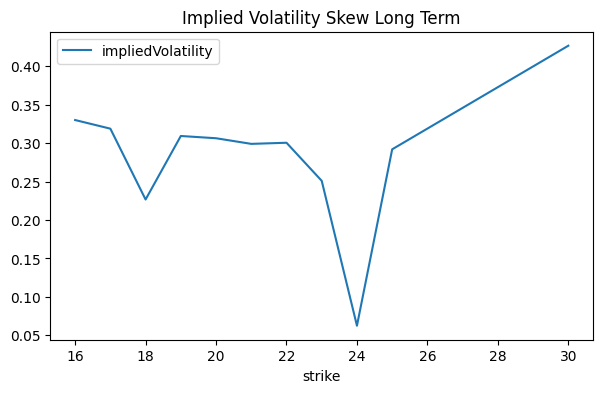

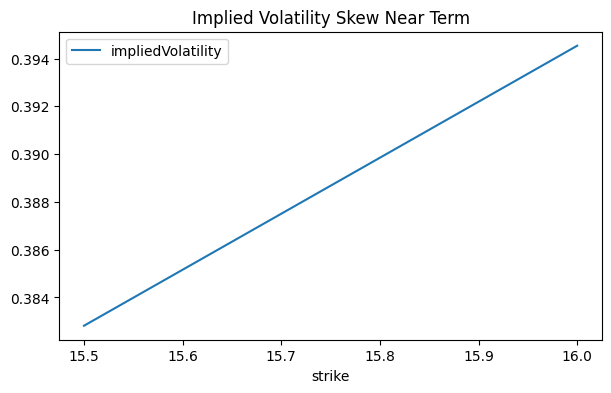

In [ ]:
# Strike / IV

calls = allOpt[allOpt['type'] == 0]

# select an expiration to plot
calls_at_expiry = calls[calls["expirationDate"] == "2026-01-16"]
calls_at_expiry_near_term = calls[calls["expirationDate"] == "2023-12-29"]

# filter out low vols
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]
calls_at_expiry_near_term = calls_at_expiry_near_term[calls_at_expiry_near_term.impliedVolatility >= 0.001]

# set the strike as the index so pandas plots nicely
filtered_calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(
    title="Implied Volatility Skew Long Term", figsize=(7, 4))
calls_at_expiry_near_term[["strike", "impliedVolatility"]].set_index("strike").plot(
    title="Implied Volatility Skew Near Term", figsize=(7, 4))

## Volatility term structure

<Axes: title={'center': 'Implied Volatility Term Structure'}, xlabel='expirationDate'>

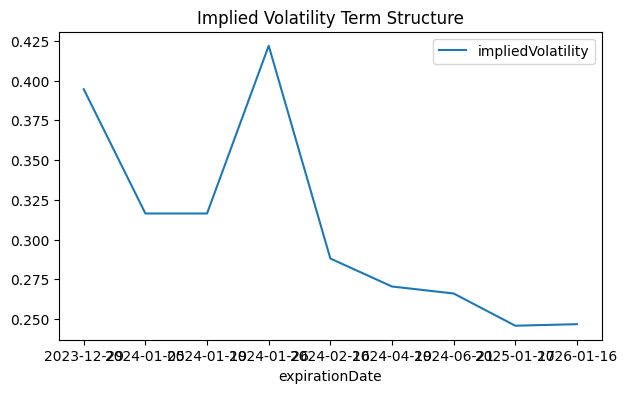

In [ ]:
# Date/ IV
# select an expiration to plot
calls_at_strike = allOpt[allOpt["strike"] == 15.0]

# filter out low vols
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]

# set the strike as the index so pandas plots nicely
filtered_calls_at_strike[["expirationDate", "impliedVolatility"]].set_index("expirationDate").plot(
    title="Implied Volatility Term Structure", figsize=(7, 4))

## Volatility Surface

In [ ]:
def calculate_days_until_expiry(df):
    # Get the current date
    current_date = datetime.now()


In [ ]:
allOpt.columns

Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'type',
       'expirationDate'],
      dtype='object')

In [ ]:
allOpt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 4 to 237
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     132 non-null    object             
 1   lastTradeDate      132 non-null    datetime64[ns, UTC]
 2   strike             132 non-null    float64            
 3   lastPrice          132 non-null    float64            
 4   bid                132 non-null    float64            
 5   ask                132 non-null    float64            
 6   change             132 non-null    float64            
 7   percentChange      132 non-null    float64            
 8   volume             119 non-null    float64            
 9   openInterest       132 non-null    int64              
 10  impliedVolatility  132 non-null    float64            
 11  inTheMoney         132 non-null    bool               
 12  contractSize       132 non-null    object         

In [ ]:
x = allOpt['strike']
y = allOpt['impliedVolatility']
z = allOpt['expirationDate']

In [ ]:
# OG CODE
# pivot the dataframe
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# create the figure object
fig = plt.figure(figsize=(10, 8))

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Call implied volatility surface')

# plot
ax.plot_surface(X, Y, z)